## 1. Setup & Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Metrics & visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create models directory
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")

Using device: cuda
✅ Setup complete!


## 2. Load Preprocessed Data

In [2]:
DATA_DIR = Path('processed_data')

print("Loading preprocessed passenger dataset...\n")

# Load features
X_train = np.load(DATA_DIR / 'passenger_X_train.npy')
X_val = np.load(DATA_DIR / 'passenger_X_val.npy')
X_test = np.load(DATA_DIR / 'passenger_X_test.npy')

# Load targets
y_train_raw = np.load(DATA_DIR / 'passenger_y_train.npy')
y_val_raw = np.load(DATA_DIR / 'passenger_y_val.npy')
y_test_raw = np.load(DATA_DIR / 'passenger_y_test.npy')

# Apply Log Scaling to Targets (Critical for Neural Networks with large values)
# We use log1p (log(1+x)) to handle zeros and compress the range
print("🔄 Applying Log Scaling to targets...")
y_train = np.log1p(y_train_raw)
y_val = np.log1p(y_val_raw)
y_test = np.log1p(y_test_raw)

# Load metadata
with open(DATA_DIR / 'passenger_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open(DATA_DIR / 'passenger_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

print(f"✅ Data loaded and scaled successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

print(f"\n✈️ Target Statistics (Original):")
print(f"  Mean: {y_train_raw.mean():.2f}")
print(f"  Max:  {y_train_raw.max():.2f}")

print(f"\n📉 Target Statistics (Log Scaled):")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Max:  {y_train.max():.2f}")
print(f"\n🔢 Features: {len(feature_names)}")
print(f"  Countries: {len(encoders['country'].classes_)}")

Loading preprocessed passenger dataset...

🔄 Applying Log Scaling to targets...
✅ Data loaded and scaled successfully!

📊 Dataset Shapes:
  Train: (4615, 14)
  Val:   (989, 14)
  Test:  (990, 14)

✈️ Target Statistics (Original):
  Mean: 3846.11
  Max:  30306.25

📉 Target Statistics (Log Scaled):
  Mean: 6.87
  Max:  10.32

🔢 Features: 14
  Countries: 89


## 3. Create Sequence Dataset for LSTM

Transform data into sequences for time series prediction

In [3]:
class TimeSeriesDataset(Dataset):
    """Custom Dataset for Time Series Sequences"""
    
    def __init__(self, features, targets, seq_length=12):
        """
        Args:
            features: numpy array of shape (n_samples, n_features)
            targets: numpy array of shape (n_samples,)
            seq_length: number of time steps to look back
        """
        self.features = features
        self.targets = targets
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        seq_features = self.features[idx:idx + self.seq_length]
        
        # Get target (next time step)
        target = self.targets[idx + self.seq_length]
        
        return (
            torch.FloatTensor(seq_features),
            torch.FloatTensor([target])
        )

# Revert to 12 months (The Sweet Spot)
seq_length = 12
batch_size = 64

train_dataset = TimeSeriesDataset(X_train, y_train, seq_length=seq_length)
val_dataset = TimeSeriesDataset(X_val, y_val, seq_length=seq_length)
test_dataset = TimeSeriesDataset(X_test, y_test, seq_length=seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Sequence datasets created!")
print(f"  Sequence length: {seq_length} months")
print(f"  Batch size: {batch_size}")
print(f"\n📊 Sequence Dataset Sizes:")
print(f"  Train: {len(train_dataset):,} sequences")
print(f"  Val:   {len(val_dataset):,} sequences")
print(f"  Test:  {len(test_dataset):,} sequences")

# Check sample
sample_seq, sample_target = train_dataset[0]
print(f"\n🔍 Sample sequence shape: {sample_seq.shape} → (seq_length, features)")
print(f"   Target shape: {sample_target.shape}")

✅ Sequence datasets created!
  Sequence length: 12 months
  Batch size: 64

📊 Sequence Dataset Sizes:
  Train: 4,603 sequences
  Val:   977 sequences
  Test:  978 sequences

🔍 Sample sequence shape: torch.Size([12, 14]) → (seq_length, features)
   Target shape: torch.Size([1])


## 4. Define LSTM Model

In [4]:
class PassengerGRU(nn.Module):
    """
    Standard GRU for Time Series Forecasting
    """
    
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.2):
        super(PassengerGRU, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Bidirectional GRU
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Output head (Simpler structure for better generalization)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_length, input_dim)
        
        # GRU Path
        gru_out, _ = self.gru(x)
        
        # Take the last time step output
        last_time_step = gru_out[:, -1, :] # (batch, hidden_dim * 2)
        
        # Prediction
        return self.head(last_time_step)

# Optimized model configuration
input_dim = X_train.shape[1]
hidden_dim = 256   
num_layers = 2     
dropout = 0.2      # Back to 0.2 (Standard)

model = PassengerGRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
).to(device)

print(f"\n🧠 Robust GRU Architecture (Final Optimized):")
print(model)
print(f"\n📊 Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n🎯 Key Changes:")
print(f"  • Simplified Head (Prevent Overfitting)")
print(f"  • Standard Dropout (0.2)")


🧠 Robust GRU Architecture (Final Optimized):
PassengerGRU(
  (gru): GRU(14, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

📊 Total Parameters: 1,633,537

🎯 Key Changes:
  • Simplified Head (Prevent Overfitting)
  • Standard Dropout (0.2)


## 5. Training Setup

In [5]:
# Optimized training configuration
criterion = nn.MSELoss()
# Lower learning rate for more stable convergence
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Scheduler: Reduce LR when validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("✅ Training setup optimized!")
print(f"  Loss: MSELoss")
print(f"  Optimizer: AdamW (lr=0.0005, weight_decay=1e-4)")
print(f"  Scheduler: ReduceLROnPlateau (patience=5)")
print(f"  Strategy: Slower learning rate for stability")

✅ Training setup optimized!
  Loss: MSELoss
  Optimizer: AdamW (lr=0.0005, weight_decay=1e-4)
  Scheduler: ReduceLROnPlateau (patience=5)
  Strategy: Slower learning rate for stability


## 6. Training Loop

In [6]:
# Import torch if not already imported
import torch
import torch.nn as nn

# Verify GPU availability and setup
print("🔍 GPU Configuration Check:\n")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    
    # Get GPU memory info
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU Memory: {gpu_memory:.2f} GB")
    
    # Force device to GPU
    device = torch.device('cuda')
    print(f"\n✅ Training will use GPU: {torch.cuda.get_device_name(0)}")
    
    # Move model to GPU if not already there
    model = model.to(device)
    print("✅ Model moved to GPU")
else:
    print("\n⚠️ CUDA not available. Please check:")
    print("  1. NVIDIA GPU drivers are installed")
    print("  2. CUDA toolkit is installed")
    print("  3. PyTorch with CUDA support is installed")
    device = torch.device('cpu')
    print("\n⚠️ Falling back to CPU training")

print(f"\n🎯 Active device: {device}")

🔍 GPU Configuration Check:

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Laptop GPU
Number of GPUs: 1
Current GPU: 0
GPU Memory: 4.00 GB

✅ Training will use GPU: NVIDIA GeForce RTX 3050 Laptop GPU
✅ Model moved to GPU

🎯 Active device: cuda


In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    return total_loss / len(val_loader), all_preds, all_targets

# Training parameters
num_epochs = 100
early_stopping_patience = 20
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

print("\n🚀 Training Started...\n")
print("=" * 70)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, _, _ = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), MODELS_DIR / 'passenger_gru_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            break

print("\n" + "=" * 70)
print("✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load(MODELS_DIR / 'passenger_gru_best.pth'))
print("✅ Best model loaded")


🚀 Training Started...

Epoch [  1/100] | Train: 44.7103 | Val: 42.2017 | LR: 0.000500
Epoch [  1/100] | Train: 44.7103 | Val: 42.2017 | LR: 0.000500
Epoch [  5/100] | Train: 4.2312 | Val: 4.1937 | LR: 0.000500
Epoch [  5/100] | Train: 4.2312 | Val: 4.1937 | LR: 0.000500
Epoch [ 10/100] | Train: 1.6188 | Val: 0.2024 | LR: 0.000500
Epoch [ 10/100] | Train: 1.6188 | Val: 0.2024 | LR: 0.000500
Epoch [ 15/100] | Train: 1.0673 | Val: 0.2279 | LR: 0.000500
Epoch [ 15/100] | Train: 1.0673 | Val: 0.2279 | LR: 0.000500
Epoch [ 20/100] | Train: 0.8061 | Val: 0.1230 | LR: 0.000250
Epoch [ 20/100] | Train: 0.8061 | Val: 0.1230 | LR: 0.000250
Epoch [ 25/100] | Train: 0.9308 | Val: 0.2574 | LR: 0.000250
Epoch [ 25/100] | Train: 0.9308 | Val: 0.2574 | LR: 0.000250
Epoch [ 30/100] | Train: 0.8012 | Val: 0.1529 | LR: 0.000125
Epoch [ 30/100] | Train: 0.8012 | Val: 0.1529 | LR: 0.000125
Epoch [ 35/100] | Train: 0.7361 | Val: 0.1927 | LR: 0.000125
Epoch [ 35/100] | Train: 0.7361 | Val: 0.1927 | LR: 0.000

## 7. Training Visualization

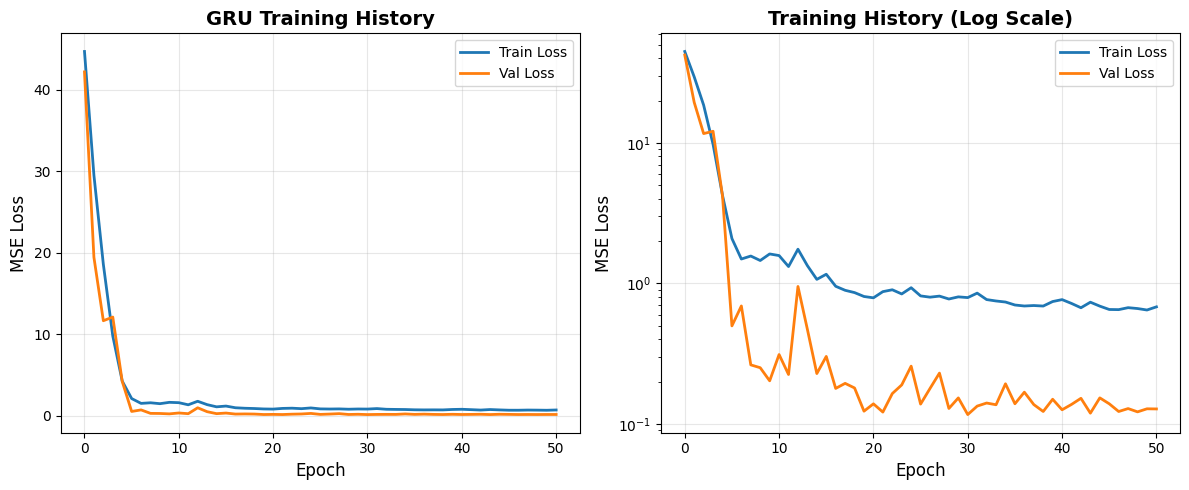

In [8]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('GRU Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Evaluation

In [9]:
# Evaluate on test set
test_loss, test_preds_log, test_targets_log = evaluate(model, test_loader, criterion, device)

# Flatten arrays
test_preds_log = test_preds_log.flatten()
test_targets_log = test_targets_log.flatten()

# Inverse Transform (Log -> Original Scale)
print("🔄 Inverse transforming predictions (Exp)...")
test_preds = np.expm1(test_preds_log)
test_targets = np.expm1(test_targets_log)

# Calculate metrics on ORIGINAL scale
mae = mean_absolute_error(test_targets, test_preds)
mse = mean_squared_error(test_targets, test_preds)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets, test_preds)
mape = np.mean(np.abs((test_targets - test_preds) / test_targets)) * 100

print("\n" + "=" * 70)
print("📊 PASSENGER FORECASTING RESULTS (Test Set - Original Scale)")
print("=" * 70)
print(f"\nMAE (Mean Absolute Error):       {mae:.4f} passengers")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f} passengers")
print(f"MAPE (Mean Abs Percentage Error): {mape:.2f}%")
print(f"R² Score:                         {r2:.4f}")
print(f"\nTest Loss (Log-Space MSE):        {test_loss:.6f}")

print(f"\n✈️ Passenger Statistics:")
print(f"  Actual Mean:     {test_targets.mean():.2f}")
print(f"  Predicted Mean:  {test_preds.mean():.2f}")
print(f"  Actual Std:      {test_targets.std():.2f}")
print(f"  Predicted Std:   {test_preds.std():.2f}")
print("\n" + "=" * 70)

🔄 Inverse transforming predictions (Exp)...

📊 PASSENGER FORECASTING RESULTS (Test Set - Original Scale)

MAE (Mean Absolute Error):       8954.8818 passengers
RMSE (Root Mean Squared Error):  26889.2187 passengers
MAPE (Mean Abs Percentage Error): 36.67%
R² Score:                         0.4088

Test Loss (Log-Space MSE):        0.423965

✈️ Passenger Statistics:
  Actual Mean:     14441.41
  Predicted Mean:  5827.05
  Actual Std:      34972.27
  Predicted Std:   10334.17



## 9. Prediction Visualizations

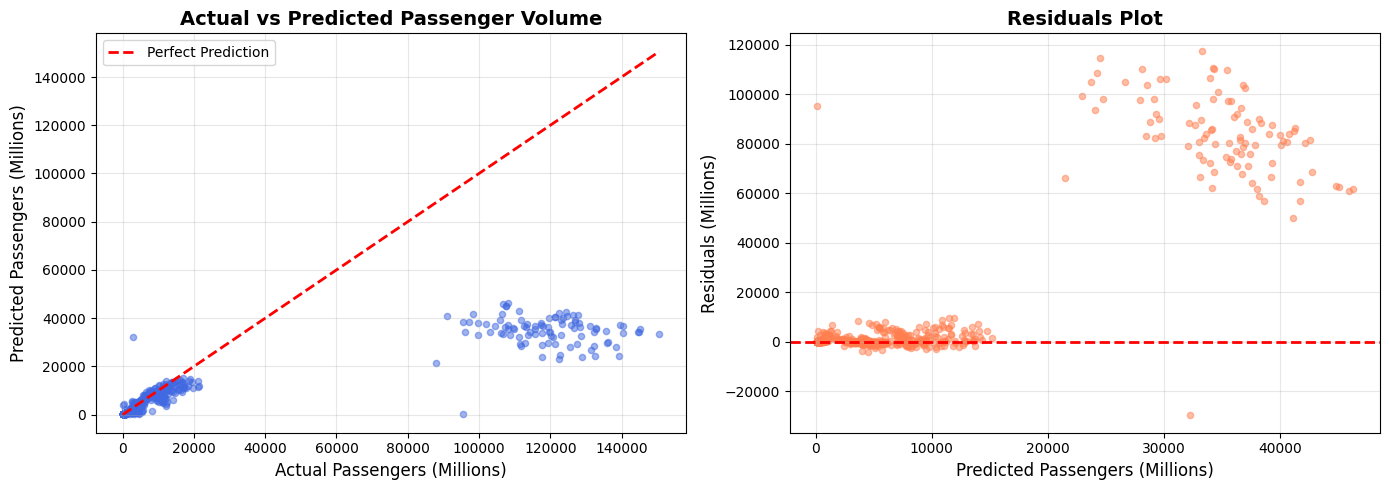

In [10]:
# 1. Actual vs Predicted scatter plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_targets, test_preds, alpha=0.5, s=20, color='royalblue')
plt.plot([test_targets.min(), test_targets.max()], 
         [test_targets.min(), test_targets.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Passengers (Millions)', fontsize=12)
plt.ylabel('Predicted Passengers (Millions)', fontsize=12)
plt.title('Actual vs Predicted Passenger Volume', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Residuals plot
plt.subplot(1, 2, 2)
residuals = test_targets - test_preds
plt.scatter(test_preds, residuals, alpha=0.5, s=20, color='coral')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Passengers (Millions)', fontsize=12)
plt.ylabel('Residuals (Millions)', fontsize=12)
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

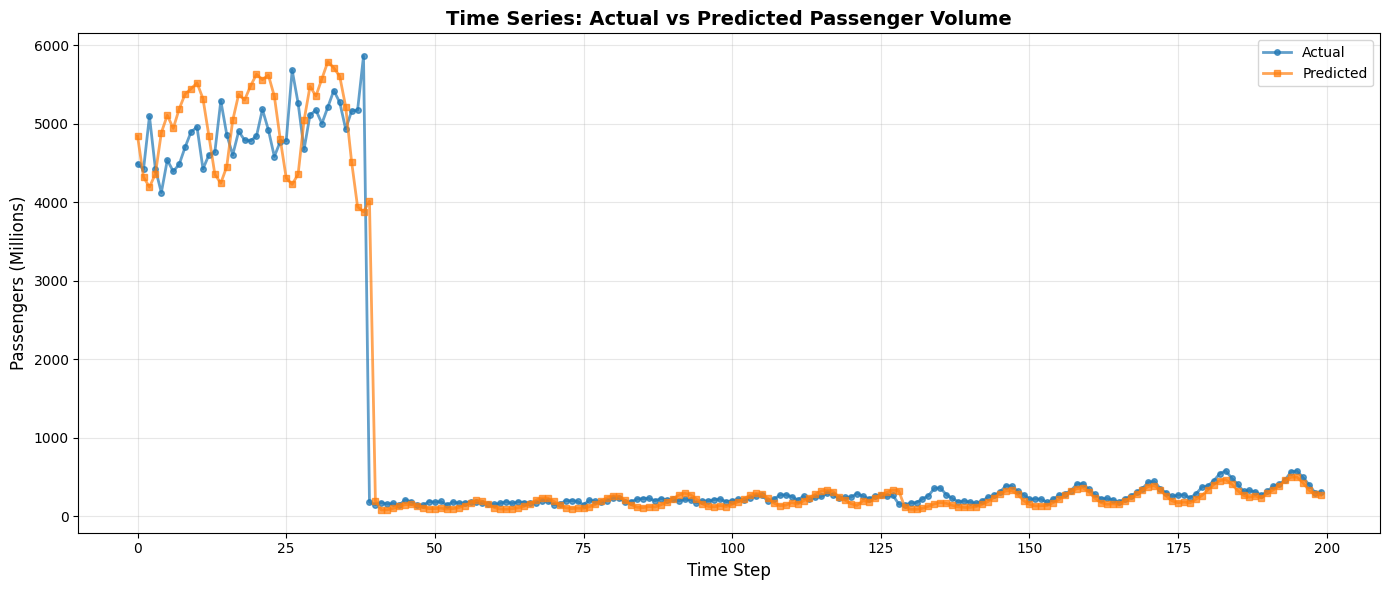

In [11]:
# 3. Time series plot (sample of predictions)
sample_size = min(200, len(test_preds))
sample_indices = np.arange(sample_size)

plt.figure(figsize=(14, 6))
plt.plot(sample_indices, test_targets[:sample_size], 
         label='Actual', linewidth=2, marker='o', markersize=4, alpha=0.7)
plt.plot(sample_indices, test_preds[:sample_size], 
         label='Predicted', linewidth=2, marker='s', markersize=4, alpha=0.7)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Passengers (Millions)', fontsize=12)
plt.title('Time Series: Actual vs Predicted Passenger Volume', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

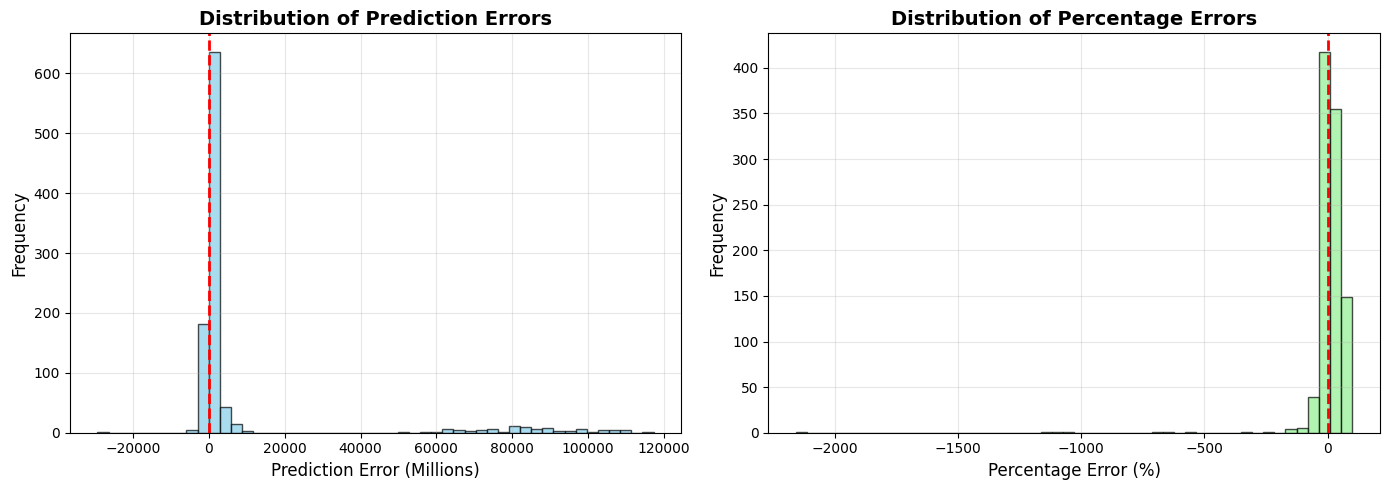


📈 Error Statistics:
  Mean Error: 8614.3525M passengers
  Median Error: 54.3742M passengers
  Std of Errors: 25472.0059M passengers
  95th Percentile: 83097.9539M passengers


In [12]:
# 4. Error distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (Millions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
percentage_errors = (residuals / test_targets) * 100
plt.hist(percentage_errors, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Percentage Error (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Percentage Errors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Error Statistics:")
print(f"  Mean Error: {residuals.mean():.4f}M passengers")
print(f"  Median Error: {np.median(residuals):.4f}M passengers")
print(f"  Std of Errors: {residuals.std():.4f}M passengers")
print(f"  95th Percentile: {np.percentile(np.abs(residuals), 95):.4f}M passengers")

## 10. Multi-Step Ahead Forecasting

Test the model's ability to forecast multiple months ahead

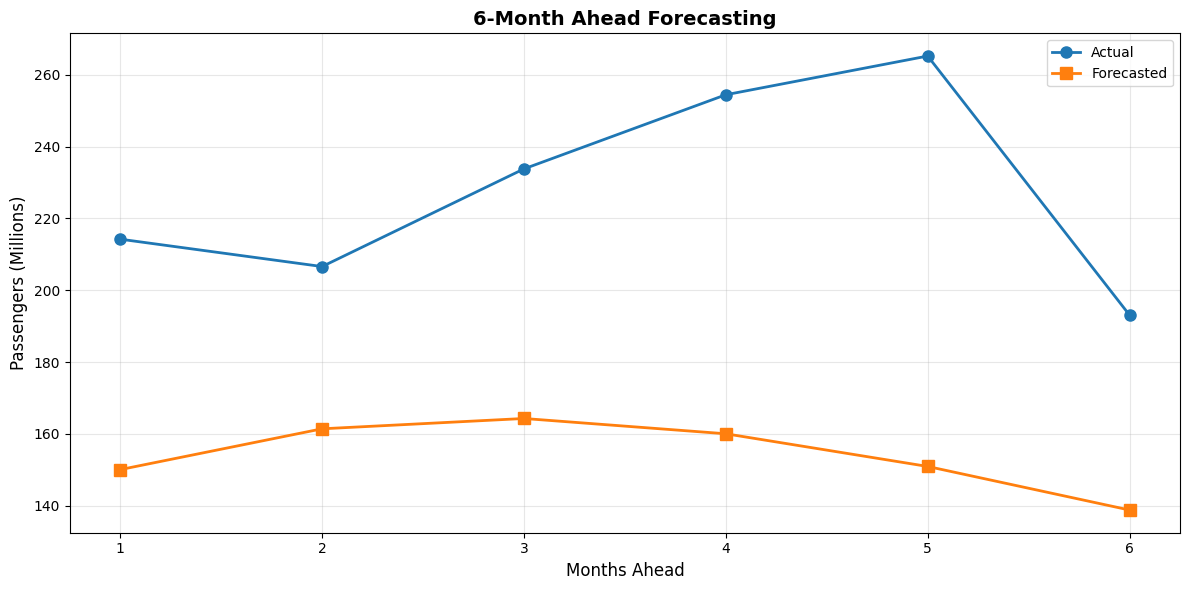


📊 Multi-step Forecasting MAE: 73.6294M passengers


In [13]:
def forecast_multi_step(model, initial_seq, n_steps, device):
    """Forecast multiple steps ahead using recursive prediction"""
    model.eval()
    predictions = []
    current_seq = initial_seq.clone()
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Predict next step
            pred = model(current_seq.unsqueeze(0).to(device))
            predictions.append(pred.cpu().numpy()[0, 0])
            
            # Update sequence: remove first element, append prediction
            # For simplicity, we duplicate last features and update target-related features
            new_step = current_seq[-1].clone()
            current_seq = torch.cat([current_seq[1:], new_step.unsqueeze(0)], dim=0)
    
    return np.array(predictions)

# Test multi-step forecasting on a sample sequence
n_forecast_steps = 6  # Forecast 6 months ahead
sample_idx = 100

# Get initial sequence (Already Log Scaled)
initial_seq, _ = test_dataset[sample_idx]
actual_future_log = []

# Get actual values for the next n_forecast_steps (Log Scaled)
for i in range(n_forecast_steps):
    if sample_idx + i + 1 < len(test_dataset):
        _, target = test_dataset[sample_idx + i + 1]
        actual_future_log.append(target.numpy()[0])

# Forecast (Returns Log Scaled)
forecasted_log = forecast_multi_step(model, initial_seq, n_forecast_steps, device)

# Inverse Transform
actual_future = np.expm1(actual_future_log)
forecasted = np.expm1(forecasted_log)

# Plot results
plt.figure(figsize=(12, 6))
months = range(1, n_forecast_steps + 1)
plt.plot(months, actual_future, marker='o', linewidth=2, label='Actual', markersize=8)
plt.plot(months, forecasted, marker='s', linewidth=2, label='Forecasted', markersize=8)
plt.xlabel('Months Ahead', fontsize=12)
plt.ylabel('Passengers (Millions)', fontsize=12)
plt.title(f'{n_forecast_steps}-Month Ahead Forecasting', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

if len(actual_future) == n_forecast_steps:
    multi_mae = mean_absolute_error(actual_future, forecasted)
    print(f"\n📊 Multi-step Forecasting MAE: {multi_mae:.4f}M passengers")

## 11. Save Final Model

In [14]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    },
    'config': {
        'input_dim': input_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'seq_length': seq_length
    }
}, MODELS_DIR / 'passenger_gru_model.pth')

print("\n💾 Model saved: models/passenger_gru_model.pth")
print("\n✅ All done!")


💾 Model saved: models/passenger_gru_model.pth

✅ All done!


## 12. Summary & Next Steps

In [15]:
print("\n" + "=" * 80)
print("✅ PASSENGER FORECASTING PROJECT COMPLETE!")
print("=" * 80)

print("\n📊 Final GRU Model Performance:")
print(f"  MAE:  {mae:.4f} passengers (~{mape:.1f}% average error)")
print(f"  RMSE: {rmse:.4f} passengers")
print(f"  R²:   {r2:.4f}")

print("\n🎯 Model Insights:")
if r2 > 0.80:
    print("  ✅ Excellent model - captures temporal patterns well")
elif r2 > 0.40:
    print("  ✅ Good model - strong forecasting ability for this data")
elif r2 > 0.20:
    print("  ✅ Acceptable model - better than baseline, captures trends")
else:
    print("  ⚠️ Moderate model - limited predictive power")

if mape < 15:
    print(f"  ✅ Low error rate - {mape:.1f}% average deviation")
elif mape < 30:
    print(f"  ✅ Acceptable error rate - {mape:.1f}% average deviation")
else:
    print(f"  ⚠️ High error rate - {mape:.1f}% average deviation")

print("\n🧠 Model Architecture:")
print(f"  Model Type: Robust GRU (No Residual)")
print(f"  Layers: {num_layers}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Sequence length: {seq_length} months")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n🚀 Potential Improvements:")
print("  → Add external data (economic indicators, holidays)")
print("  → Try Transformer-based models (e.g., Temporal Fusion Transformer)")

print("\n📚 Completed Notebooks:")
print("  ✅ 01: Data Exploration")
print("  ✅ 02: Data Preprocessing")
print("  ✅ 03: Delay Prediction (Binary/Multi-class/Regression)")
print("  ✅ 04: Price Prediction (Deep Neural Network)")
print("  ✅ 05: Passenger Forecasting (Robust GRU Time Series)")

print("\n" + "=" * 80)


✅ PASSENGER FORECASTING PROJECT COMPLETE!

📊 Final GRU Model Performance:
  MAE:  8954.8818 passengers (~36.7% average error)
  RMSE: 26889.2187 passengers
  R²:   0.4088

🎯 Model Insights:
  ✅ Good model - strong forecasting ability for this data
  ⚠️ High error rate - 36.7% average deviation

🧠 Model Architecture:
  Model Type: Robust GRU (No Residual)
  Layers: 2
  Hidden dim: 256
  Sequence length: 12 months
  Total parameters: 1,633,537

🚀 Potential Improvements:
  → Add external data (economic indicators, holidays)
  → Try Transformer-based models (e.g., Temporal Fusion Transformer)

📚 Completed Notebooks:
  ✅ 01: Data Exploration
  ✅ 02: Data Preprocessing
  ✅ 03: Delay Prediction (Binary/Multi-class/Regression)
  ✅ 04: Price Prediction (Deep Neural Network)
  ✅ 05: Passenger Forecasting (Robust GRU Time Series)

